## Libraries - Parameters

In [84]:
# Basic libraries
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
# Visualization library
import matplotlib.pyplot as plt
# User's library
from utils.PerformanceProfiles import *
from utils.non_parametric_tests import *


# TWINS, Synthetic, IHDP
Problem = "ACIC"

# Get files
PATH = './Results/'
Files = [f for f in listdir(PATH) if isfile(join(PATH, f))]

## Load data

In [85]:
Methods = []
for i, file in enumerate( Files ):
    # Select only csv files
    #
    if ('.csv' not in file): continue
        
    # Select on results from selected Problem
    #
    if ( Problem not in file ): continue
        
        
    # Get method name
    #
    Method = file.split('.csv')[0].split('_')[1]
    
    Methods += [ Method ]

# Sort list with methods
Methods.sort()

for i, x in enumerate( Methods ):
    print('%2i: %s' % (i+1, x))

 1: C-Forest
 2: DragonNet
 3: LR1
 4: LR2
 5: R-Forest
 6: XGBoost
 7: kNN-DragonNet-euclidean-k=11


#### Select Methods/Solvers 

In [86]:
SelectedMethods = [
                    # "LR1",
                    # "LR2",
                    "R-Forest",
                    "C-Forest",
                    "DragonNet",
                    "kNN-DragonNet-euclidean-k=11",
                    "XGBoost",                    
]

#### Merge files

In [87]:
Error_ATE  = pd.DataFrame([])
Error_PEHE = pd.DataFrame([])

for i, file in enumerate( Files ):
    # Select only csv files
    if ('.csv' not in file): continue
        
    # Select on results from IHDP
    if (Problem != file.split("_")[0]): continue
    
    
    # Select methods
    Method = file.split('.csv')[0].split('_')[1]
    if (Method not in SelectedMethods): continue
    
    # Open DataFrame
    df = pd.read_csv(PATH + file)
    
    if (Error_ATE.shape[0] == 0):
        Error_ATE['Problem'], Error_PEHE['Problem']  = df.Problem, df.Problem

    Error_ATE[Method], Error_PEHE[Method]  = df['Error_ATE'], df['Error_PEHE']

    

# Set index
Error_ATE.set_index('Problem', inplace = True)
Error_PEHE.set_index('Problem', inplace = True)

# Remove NaN rows if any
Error_ATE.dropna(inplace=True)
Error_PEHE.dropna(inplace=True)

Error_ATE, Error_PEHE = Error_ATE[SelectedMethods], Error_PEHE[SelectedMethods]

print('[INFO] nProblem: ', Error_ATE.shape[0])

[INFO] nProblem:  34


In [88]:
if Problem == "ACIC":
       L = ['ACIC 0', 'ACIC 1', 'ACIC 2', 'ACIC 5', 'ACIC 9', 'ACIC 13', 'ACIC 14',
              'ACIC 15', 'ACIC 17', 'ACIC 18', 'ACIC 22', 'ACIC 24', 'ACIC 25',
              'ACIC 26', 'ACIC 27']

       Error_ATE = Error_ATE[ Error_PEHE.index.isin(L) ]
       Error_PEHE = Error_PEHE[ Error_PEHE.index.isin(L) ]

## Performance profiles

### Error ATE

Method: R-Forest - 0.23
Method: C-Forest - 0.15
Method: DragonNet - 0.15
Method: kNN-DragonNet-euclidean-k=11 - 0.23
Method: XGBoost - 0.23


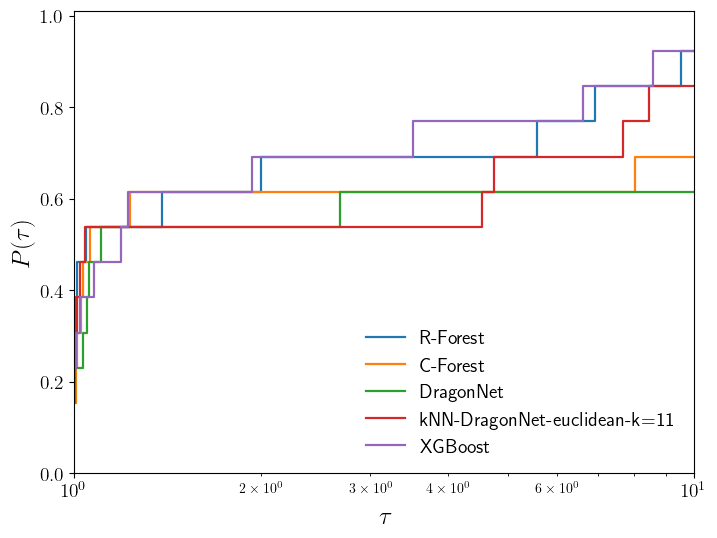

In [89]:
perfprof(Error_ATE.values, 
        #  linespecs = ['b-', 'r-', 'g--', 'm-.', 'c-.',  'y-', 'k-.'], 
         digit = 3,
        #  legendnames = ["\\textsc{Causal-Siamese} ($L_1$)", "\\textsc{Causal-Siamese} ($L_2$)", '\\textsc{Dragonnet}', "$k$\\textsc{NN-Dragonnet}", "\\textsc{NEDnet}", "\\textsc{R-Forest}", "\\textsc{C-Forest}"],
         legendnames = Error_ATE.columns,
         thmax = 10, figsize = (8, 6) )

plt.xscale('log')

plt.savefig( 'images/{}_Error_ATE.png'.format(Problem), dpi = 300 )

### Error PEHE

[INFO] nProblem:  13
Method: R-Forest - 0.38
Method: C-Forest - 0.00
Method: DragonNet - 0.00
Method: kNN-DragonNet-euclidean-k=11 - 0.00
Method: XGBoost - 0.62


c:\Users\ioann\OneDrive\Desktop\Causal_XGBoost\utils\PerformanceProfiles.py:103: RuntimeWarning: divide by zero encountered in true_divide
  col = data[:, alt] / minvals  # performance ratio
c:\Users\ioann\OneDrive\Desktop\Causal_XGBoost\utils\PerformanceProfiles.py:103: RuntimeWarning: invalid value encountered in true_divide
  col = data[:, alt] / minvals  # performance ratio


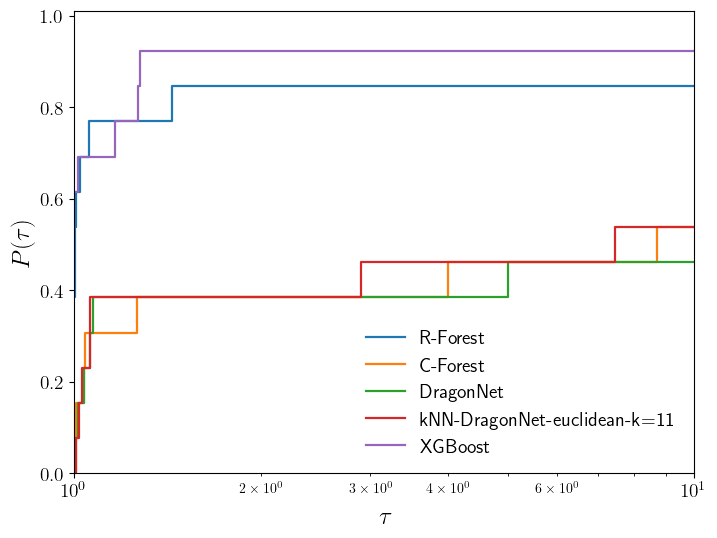

In [95]:
print('[INFO] nProblem: ', Error_ATE.shape[0])

perfprof(Error_PEHE,
        #  linespecs = ['b-', 'r-', 'g--', 'm-.', 'c-.',  'y-', 'k-.'], 
         digit = 3,
        #  legendnames = ["\\textsc{Causal-Siamese} ($L_1$)", "\\textsc{Causal-Siamese} ($L_2$)", '\\textsc{Dragonnet}', "$k$\\textsc{NN-Dragonnet}", "\\textsc{NEDnet}", "\\textsc{R-Forest}", "\\textsc{C-Forest}"],
         legendnames = Error_ATE.columns,
         thmax = 10, figsize = (8, 6) )

plt.xscale('log')

plt.savefig( 'images/{}_Error_PEHE.png'.format(Problem), dpi = 300 )

## Statistical analysis

### ATE

#### Friedman Aligned Ranking (FAR)

In [91]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( Error_ATE )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')


Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = Error_ATE.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

[INFO] Number of methods:   5
[INFO] Number of problems:  13


[INFO] H0: {All methods exhibited similar results with no statistical differences}
[INFO] FAR: 13.760 (p-value: 0.00810)
	> H0 is rejected


,Methods,FAR
0,XGBoost,22.307692
1,R-Forest,22.615385
2,kNN-DragonNet-euclidean-k=11,34.307692
3,DragonNet,42.230769
4,C-Forest,43.538462


#### Finner post-hoc test

**Multiple comparisons ($1 \times N$)**

In [92]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( Error_ATE.columns ):
    d[ feature ] = rankings_cmp[i] 
    
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner

[INFO] Control method:  XGBoost


,Comparisons,APV,Null hypothesis
0,XGBoost vs R-Forest,0.966906,Failed to reject
1,XGBoost vs kNN-DragonNet-euclidean-k=11,0.138319,Failed to reject
2,XGBoost vs C-Forest,0.016693,Rejected
3,XGBoost vs DragonNet,0.016693,Rejected


### PEHE

#### Friedman Aligned Ranking (FAR)

In [93]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( Error_PEHE )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')


Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = Error_PEHE.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

[INFO] Number of methods:   5
[INFO] Number of problems:  13


[INFO] H0: {All methods exhibited similar results with no statistical differences}
[INFO] FAR: 23.408 (p-value: 0.00010)
	> H0 is rejected


,Methods,FAR
0,R-Forest,18.692308
1,XGBoost,18.692308
2,kNN-DragonNet-euclidean-k=11,38.769231
3,C-Forest,42.307692
4,DragonNet,46.538462


#### Finner post-hoc test

**Multiple comparisons ($1 \times N$)**

In [94]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( Error_PEHE.columns ):
    d[ feature ] = rankings_cmp[i] 
    
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner

[INFO] Control method:  R-Forest


,Comparisons,APV,Null hypothesis
0,R-Forest vs XGBoost,1.000000,Failed to reject
1,R-Forest vs kNN-DragonNet-euclidean-k=11,0.009038,Rejected
2,R-Forest vs C-Forest,0.002900,Rejected
3,R-Forest vs DragonNet,0.000694,Rejected
